### Super Store Dataset Analysis & Visualisation


<p aligh='justify'>This notebook proivdes descriptive analysis of the Super Store dataset. To reproduce data structure in database follow instructions in "Config/ProjectSetup.md". Dataset includes fully detailed information about orders in SuperStore.</p>

Information provided in dataset: 
* Row ID - unique identifier of the record 
* Order ID - identifier of particular order 
* Order Date - purchase order timestamp 
* Ship Date - delivery timestamp 
* Ship Mode - picked delivery option 
* Customer ID - unique identifier of the customer 
* Customer Name - name & and surnmae of customer 
* Segment - customer's segment e.g. customer classification 
* Country - customer country (data only for US)
* City - customer city 
* State - customer state 
* Postal Code - unique identifier of the customer localization 
* Region - particular region of the US
* Product ID - product identifier (unfortunately not unique)
* Category - product main category 
* Sub-Category - additional category of the product 
* Sales - sum of sales for order 
* Quantity - amount of the product 
* Discount - discount rate 
* Profit - total profit from order 


<p align='justify'>For analysis purpose column Country is removed from database - it has not brought any value or information. Additionaly unique record identifier and unique order identifier has been derived.  </p>

Dependency resolving and sql extension laod.

In [ ]:
%pip install -r config/requirements.txt

In [ ]:
%load_ext sql

In [148]:
%sql mssql+pyodbc://PLLUKOR1@local

Libriaries import

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Warnings cleanup

In [150]:
import warnings
warnings.filterwarnings("ignore")

Data sample

In [151]:
%%sql 
use SuperStore;

SELECT  TOP 5
        A.OderDate
       ,A.ShipDate
       ,B.ShipModeName
       ,C.CustomerID
       ,C.CustomerName
       ,D.SegmentName
       ,F.CityName
       ,G.StateName
       ,H.RegionName
       ,E.PostalCode
       ,I.ProductID
       ,K.CategoryName
       ,J.SubCategoryName
       ,I.ProductName
       ,A.Sales
       ,A.Quantity
       ,A.Discount
       ,A.Profit
FROM Orders A
LEFT JOIN ShipModels B
ON A.ShipModeID = B.ShipModeID
LEFT JOIN Customers C
ON A.CustomerID = C.CustomerID
LEFT JOIN Segments D
ON C.SegmentID = D.SegmentID
LEFT JOIN Localisations E
ON C.PostalCode = E.PostalCode
LEFT JOIN Cities F
ON E.CityID = F.CityID
LEFT JOIN States G
ON E.StateID = G.StateID
LEFT JOIN Regions H
ON E.RegionID = H.RegionID
LEFT JOIN Products I
ON A.UniqueProductID = I.UniqueProductID
LEFT JOIN SubCategories J
ON I.SubCategoryID = J.SubCategoryID
LEFT JOIN Categories K
ON J.CategoryID = K.CategoryID;

 * mssql+pyodbc://PLLUKOR1@local
Done.
Done.


OderDate,ShipDate,ShipModeName,CustomerID,CustomerName,SegmentName,CityName,StateName,RegionName,PostalCode,ProductID,CategoryName,SubCategoryName,ProductName,Sales,Quantity,Discount,Profit
2016-08-11 00:00:00,2016-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,42420,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.00,41.91
2016-08-11 00:00:00,2016-11-11 00:00:00,Second Class,CG-12520,Claire Gute,Consumer,Henderson,Kentucky,South,42420,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.94,3,0.00,219.58
2016-12-06 00:00:00,2016-06-16 00:00:00,Second Class,DV-13045,Darrin Van Huff,Corporate,Los Angeles,California,West,90036,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters by Universal,14.62,2,0.00,6.87
2015-11-10 00:00:00,2015-10-18 00:00:00,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,South,33311,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.58,5,0.45,-383.03
2015-11-10 00:00:00,2015-10-18 00:00:00,Standard Class,SO-20335,Sean O'Donnell,Consumer,Fort Lauderdale,Florida,South,33311,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.37,2,0.20,2.52


TOP 10 States by Sales

In [152]:
query = '''
SELECT  TOP 10 C.StateName
       ,SUM(A.Sales) AS 'Sum'
       ,AVG(A.Sales) AS Average
       ,MIN(A.Sales) AS Minimum
       ,MAX(A.Sales) AS Maximum
FROM Orders A
JOIN Localisations B
ON A.PostalCode = B.PostalCode
JOIN States C
ON B.StateID = C.StateID
GROUP BY  C.StateName
ORDER BY SUM(A.Sales) DESC;
'''
result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,StateName,Sum,Average,Minimum,Maximum
0,California,450041.53,229.378965,0.99,8187.65
1,New York,310876.20,275.599468,1.24,11199.97
2,Texas,170187.98,172.779675,0.44,8159.95
3,Washington,138641.29,273.994644,1.34,13999.96
4,Pennsylvania,116512.02,198.487257,0.85,8399.98
5,Florida,89473.73,233.612872,1.17,22638.48
6,Illinois,80166.16,162.939349,0.84,2799.96
7,Ohio,78258.21,166.861855,1.45,4499.99
8,Michigan,76269.61,299.096509,2.20,9892.74
9,Virginia,70636.72,315.342500,2.84,8749.95


 * mssql+pyodbc://PLLUKOR1@local
Done.


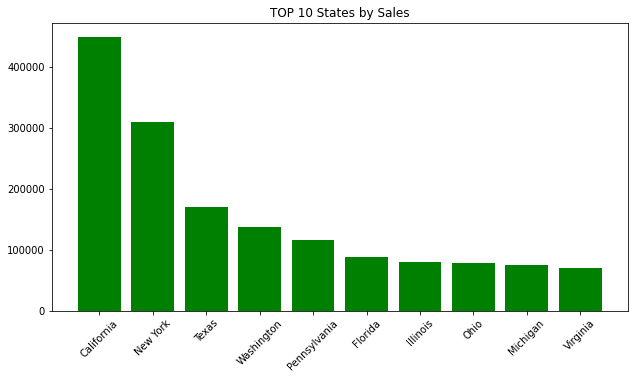

In [153]:
query = '''
SELECT TOP 10 C.StateName
       ,SUM(A.Sales) AS 'Sum'
FROM Orders A
JOIN Localisations B
ON A.PostalCode = B.PostalCode
JOIN States C
ON B.StateID = C.StateID
GROUP BY  C.StateName
ORDER BY SUM(A.Sales) DESC;
'''
result = %sql $query
result = pd.DataFrame(result)

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes((.1, .4, .8, .5))
ax.bar(result['StateName'],result['Sum'], color='green')
ax.set_title('TOP 10 States by Sales')
plt.xticks(rotation=45)
plt.show()

In [154]:
query = '''
SELECT  C.RegionName
       ,SUM(A.Sales) AS 'Sum'
       ,AVG(A.Sales) AS Average
       ,MIN(A.Sales) AS Minimum
       ,MAX(A.Sales) AS Maximum
FROM Orders A
JOIN Localisations B
ON A.PostalCode = B.PostalCode
JOIN Regions C
ON B.RegionID = C.RegionID
GROUP BY  C.RegionName;
'''

result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,RegionName,Sum,Average,Minimum,Maximum
0,East,678781.36,238.336151,0.85,11199.97
1,South,391721.90,241.803641,1.17,22638.48
2,West,717811.78,226.868451,0.99,13999.96
3,Central,501239.88,215.772656,0.44,17499.95


Regions by Sales

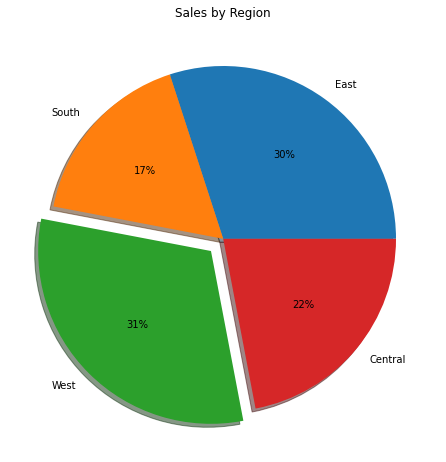

In [155]:
percentages = [float(round(x/sum(result['Sum']), 2)) for x in result['Sum']]

fig = plt.figure(figsize=(12,12))
axes = fig.add_axes((.1, .4, .8, .5))
axes.pie(percentages,labels=result['RegionName'], explode=[0, 0, 0.1, 0],
             shadow=True,autopct='%1.0f%%',)
axes.set_title('Sales by Region')
plt.show()

TOP 10 Customers

In [156]:
query = '''
SELECT  TOP 10 B.CustomerName 
       ,SUM(A.Sales) AS 'Sum'
       ,AVG(A.Sales) AS Average
       ,MIN(A.Sales) AS Minimum
       ,MAX(A.Sales) AS Maximum
FROM Orders A
JOIN Customers B 
ON A.CustomerID = B.CustomerID
GROUP BY  B.CustomerName 
ORDER BY SUM(A.Sales) DESC
'''

result = %sql $query
result = pd.DataFrame(result)
result


 * mssql+pyodbc://PLLUKOR1@local
Done.


,CustomerName,Sum,Average,Minimum,Maximum
0,Sean Miller,25043.07,1669.538000,3.49,22638.48
1,Tamara Chand,19052.22,1587.685000,7.31,17499.95
2,Raymond Buch,15117.35,839.852777,4.45,13999.96
3,Tom Ashbrook,14595.62,1459.562000,7.04,11199.97
4,Adrian Barton,14473.57,723.678500,3.69,9892.74
5,Ken Lonsdale,14175.23,488.801034,1.19,8187.65
6,Sanjit Chand,14142.34,642.833636,5.04,9449.95
7,Hunter Lopez,12873.30,1170.300000,6.63,10499.97
8,Sanjit Engle,12209.44,642.602105,5.95,8749.95
9,Christopher Conant,12129.08,1102.643636,1.25,8399.98


 * mssql+pyodbc://PLLUKOR1@local
Done.
 * mssql+pyodbc://PLLUKOR1@local
Done.


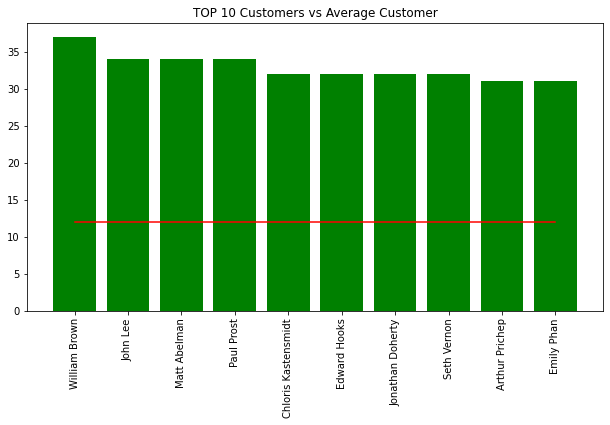

In [157]:
query = '''
SELECT  TOP 10 B.CustomerName 
        ,COUNT(A.Sales) AS TotalOrders
FROM Orders A
JOIN Customers B 
ON A.CustomerID = B.CustomerID
GROUP BY  B.CustomerName 
ORDER BY Count(A.Sales) DESC;
'''

mean = '''
SELECT AVG(O.TotalOrders) as Average
FROM (SELECT B.CustomerName 
        ,COUNT(A.Sales) AS TotalOrders
FROM Orders A
JOIN Customers B 
ON A.CustomerID = B.CustomerID
GROUP BY  B.CustomerName ) AS o;
'''

result = %sql $query
result = pd.DataFrame(result)

mean = %sql $mean
mean = pd.DataFrame(10*mean)




fig = plt.figure(figsize=(10,8))
ax = fig.add_axes((.1, .4, .8, .5))
ax.bar(result['CustomerName'], result['TotalOrders'], color='green')
ax.plot(result['CustomerName'], mean['Average'], color='red')
ax.set_title('TOP 10 Customers vs Average Customer')
plt.xticks(rotation=90)
plt.show()


Most Frequent Products

In [158]:
query = '''
SELECT  top 10 B.ProductName
       ,COUNT(A.Sales) AS TotalSales
FROM Orders A
JOIN Products B
ON A.UniqueProductID = B.UniqueProductID
GROUP BY  B.ProductName
ORDER BY TotalSales DESC;
'''

result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,ProductName,TotalSales
0,Staple envelope,48
1,Staples,46
2,Easy-staple paper,46
3,Avery Non-Stick Binders,20
4,Staples in misc. colors,19
5,Xerox 1881,19
6,Imation 16GB Mini TravelDrive USB 2.0 Flash Drive,18
7,KI Adjustable-Height Table,18
8,Staple remover,18
9,Storex Dura Pro Binders,17


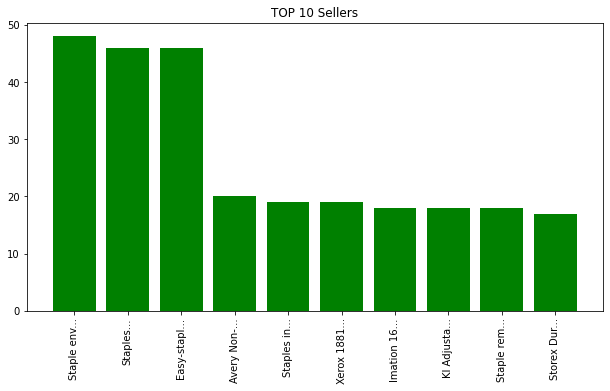

In [159]:
result['ProductName'] = [x[:10]+'...' for x in result['ProductName']]

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes((.1, .4, .8, .5))
ax.bar(result['ProductName'],result['TotalSales'], color='green')
ax.set_title('TOP 10 Sellers')
plt.xticks(rotation=90)
plt.show()

Most profitable products

In [160]:
query = '''
SELECT  TOP 10 B.ProductName
       ,COUNT(A.Sales) AS TotalSold
       ,SUM(A.Sales)   AS TotalSales
       ,SUM(A.Profit) AS TotalProfit
FROM Orders A
JOIN Products B
ON A.UniqueProductID = B.UniqueProductID
GROUP BY  B.ProductName
ORDER BY TotalProfit DESC;
'''

result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,ProductName,TotalSold,TotalSales,TotalProfit
0,Canon imageCLASS 2200 Advanced Copier,5,61599.83,25199.94
1,Fellowes PB500 Electric Punch Plastic Comb Bin...,10,27453.38,7753.06
2,Hewlett Packard LaserJet 3310 Copier,8,18839.68,6983.89
3,Canon PC1060 Personal Laser Copier,4,11619.83,4570.94
4,Logitech G19 Programmable Gaming Keyboard,14,13384.57,4358.37
5,HP Designjet T520 Inkjet Large Format Printer ...,3,18374.90,4094.98
6,Ativa V4110MDD Micro-Cut Shredder,2,7699.89,3772.95
7,"3D Systems Cube Printer, 2nd Generation, Magenta",2,14299.89,3717.97
8,Ibico EPK-21 Electric Binding System,3,15875.92,3345.29
9,Zebra ZM400 Thermal Label Printer,2,6965.70,3343.53


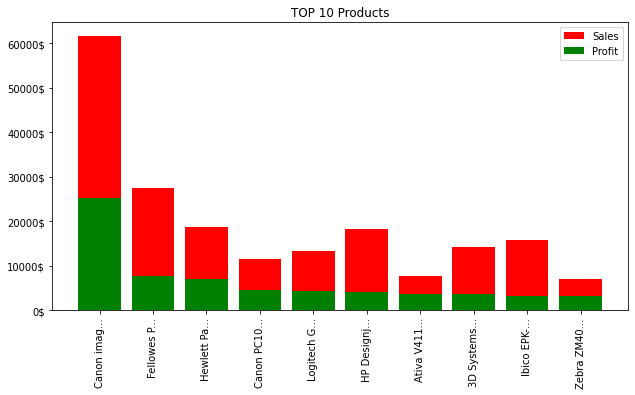

In [161]:
result['ProductName'] = [x[:10]+'...' for x in result['ProductName']]

fig = plt.figure(figsize=(10,8))
ax = fig.add_axes((.1, .4, .8, .5))
ax.bar(result['ProductName'],result['TotalSales'], color='red')
ax.bar(result['ProductName'],result['TotalProfit'], color='green')
ax.set_title('TOP 10 Products')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d$'))
plt.legend(['Sales', 'Profit'])
plt.show()

Sales By Categories

In [162]:
query = '''
SELECT D.CategoryName
       ,COUNT(A.Sales) AS TotalSold
       ,SUM(A.Sales)   AS TotalSales
       ,SUM(A.Profit) AS TotalProfit
FROM Orders A
JOIN Products B
ON A.UniqueProductID = B.UniqueProductID
JOIN SubCategories C 
ON B.SubCategoryID = C.SubCategoryID 
JOIN Categories D
ON C.CategoryID = D.CategoryID
GROUP BY D.CategoryName
ORDER BY TotalProfit desc;
'''

result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,CategoryName,TotalSold,TotalSales,TotalProfit
0,Technology,1838,833382.31,144790.98
1,Office Supplies,6005,717746.30,121991.91
2,Furniture,2112,738426.31,18153.55


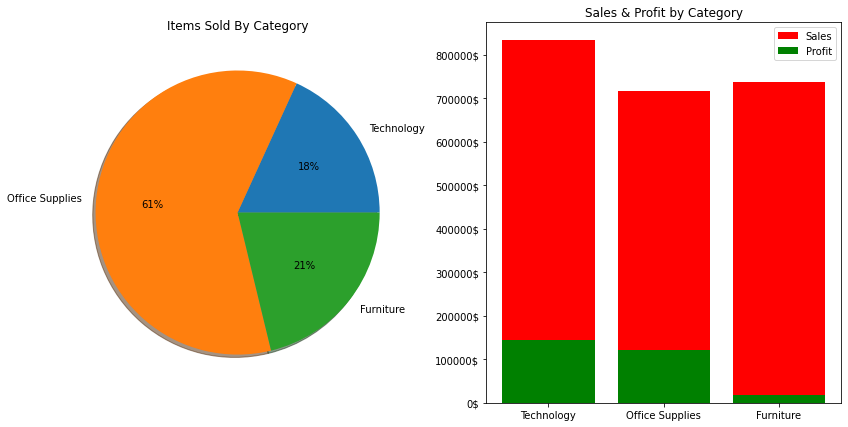

In [163]:
percentages = [float(round(x/sum(result['TotalSold']), 2)) for x in result['TotalSold']]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(percentages,labels=result['CategoryName'],
             shadow=True,autopct='%1.0f%%')
axes[0].set_title('Items Sold By Category')

axes[1].bar(result['CategoryName'],result['TotalSales'], color='red')
axes[1].bar(result['CategoryName'],result['TotalProfit'], color='green')
axes[1].set_title('Sales & Profit by Category')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d$'))
plt.legend(['Sales', 'Profit'])

plt.show()

Sales by Subcategories

In [164]:
query = '''
SELECT C.SubCategoryName
       ,COUNT(A.Sales) AS TotalSold
       ,SUM(A.Sales)   AS TotalSales
       ,SUM(A.Profit) AS TotalProfit
FROM Orders A
JOIN Products B
ON A.UniqueProductID = B.UniqueProductID
JOIN SubCategories C 
ON B.SubCategoryID = C.SubCategoryID 
GROUP BY C.SubcategoryName
ORDER BY TotalProfit DESC;
'''

result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,SubCategoryName,TotalSold,TotalSales,TotalProfit
0,Copiers,67,148328.03,55182.91
1,Phones,885,328957.54,44417.46
2,Accessories,771,166858.06,41805.88
3,Paper,1364,78048.76,33849.15
4,Binders,1515,203012.26,30080.24
5,Chairs,614,326325.91,26382.71
6,Storage,846,223843.59,21279.05
7,Appliances,465,107456.02,18116.00
8,Furnishings,954,91347.63,12955.34
9,Envelopes,253,16432.68,6943.56


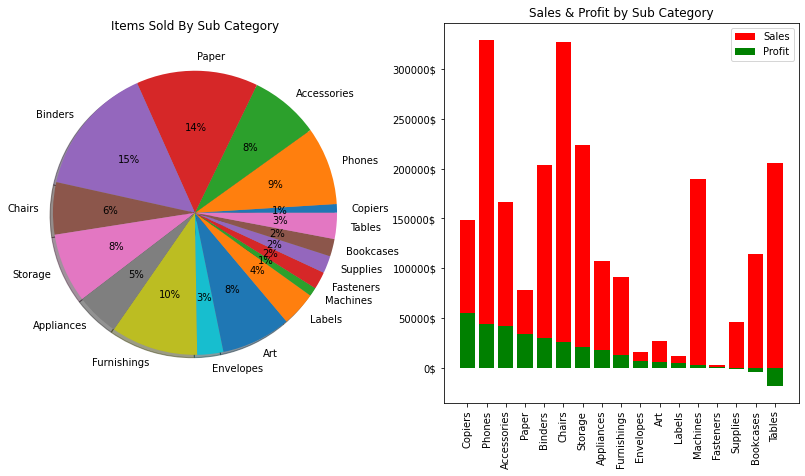

In [165]:
percentages = [float(round(x/sum(result['TotalSold']), 2)) for x in result['TotalSold']]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(percentages,labels=result['SubCategoryName'],
             shadow=True,autopct='%1.0f%%')
axes[0].set_title('Items Sold By Sub Category')



axes[1].bar(result['SubCategoryName'],result['TotalSales'], color='red')
axes[1].bar(result['SubCategoryName'],result['TotalProfit'], color='green')
axes[1].set_title('Sales & Profit by Sub Category')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d$'))
plt.xticks(rotation=90)
plt.legend(['Sales', 'Profit'])

plt.show()

Sales & Profit By Year

In [166]:
query = '''
SELECT  YEAR(OderDate) AS 'Year'
       ,COUNT(Sales)   AS TotalSold
       ,SUM(Sales)     AS TotalSales
       ,SUM(Profit)    AS TotalProfit
       , CONCAT(CAST(SUM(Profit)/SUM(Sales)*100 
              AS DECIMAL(10,2)), '%') as ProfitRatio
FROM Orders
GROUP BY  YEAR(OderDate)
ORDER BY Year asc;
'''

result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,Year,TotalSold,TotalSales,TotalProfit,ProfitRatio
0,2014,1980,480113.28,48690.21,10.14%
1,2015,2096,469726.96,61404.95,13.07%
2,2016,2578,607472.25,81686.60,13.45%
3,2017,3301,732242.43,93154.68,12.72%


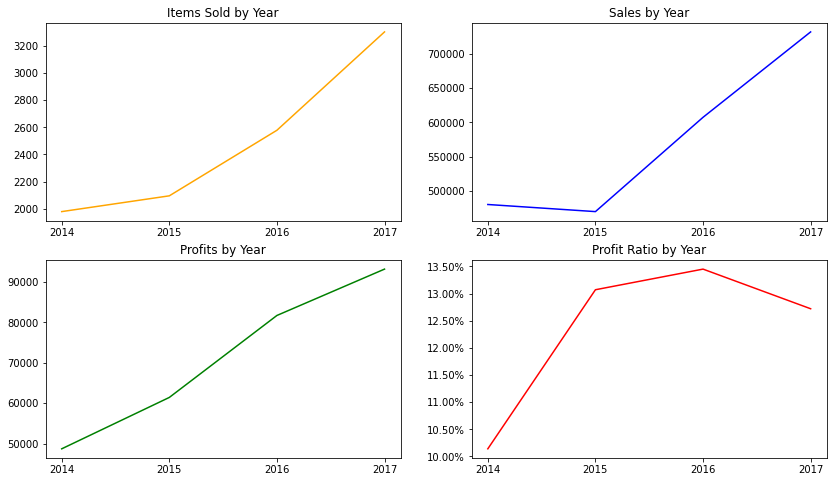

In [167]:
result['ProfitRatio'] = [float(x.replace('%', '')) for x in result['ProfitRatio']]
ticks = [2014, 2015, 2016, 2017]

fig, axes = plt.subplots(2, 2,figsize=(14, 8))

axes[0][0].plot(result['Year'], result['TotalSold'], color='orange')
axes[0][0].set_title('Items Sold by Year')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d$'))
axes[0][0].set_xticks(ticks)


axes[0][1].plot(result['Year'], result['TotalSales'], color='blue')
axes[0][1].set_title('Sales by Year')
axes[0][1].set_xticks(ticks)

axes[1][0].plot(result['Year'], result['TotalProfit'], color='green')
axes[1][0].set_title('Profits by Year')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d$'))
axes[1][0].set_xticks(ticks)


axes[1][1].plot(result['Year'], result['ProfitRatio'], color='red')
axes[1][1].set_title('Profit Ratio by Year')
axes[1][1].set_xticks(ticks)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())

plt.show() 

Monthly trends

In [176]:
query = '''
SELECT MONTH(OderDate) AS 'Month'
       ,COUNT(Sales)    AS TotalSold
       ,SUM(Sales)      AS TotalSales
       ,SUM(Profit)     AS TotalProfit
       , CONCAT(CAST(SUM(Profit)/SUM(Sales)*100 
              AS DECIMAL(10,2)), '%') as ProfitRatio
FROM Orders
GROUP BY  MONTH(OderDate)
ORDER BY Month asc;
'''

result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,Month,TotalSold,TotalSales,TotalProfit,ProfitRatio
0,1,597,161083.61,25167.08,15.62%
1,2,548,132721.37,23753.71,17.90%
2,3,818,219898.28,29256.68,13.30%
3,4,693,146874.32,12209.90,8.31%
4,5,823,166021.89,24182.79,14.57%
5,6,704,144724.22,21117.72,14.59%
6,7,737,160935.10,9960.75,6.19%
7,8,810,207537.56,24146.53,11.63%
8,9,1137,248980.77,34551.21,13.88%
9,10,807,184320.05,22324.87,12.11%


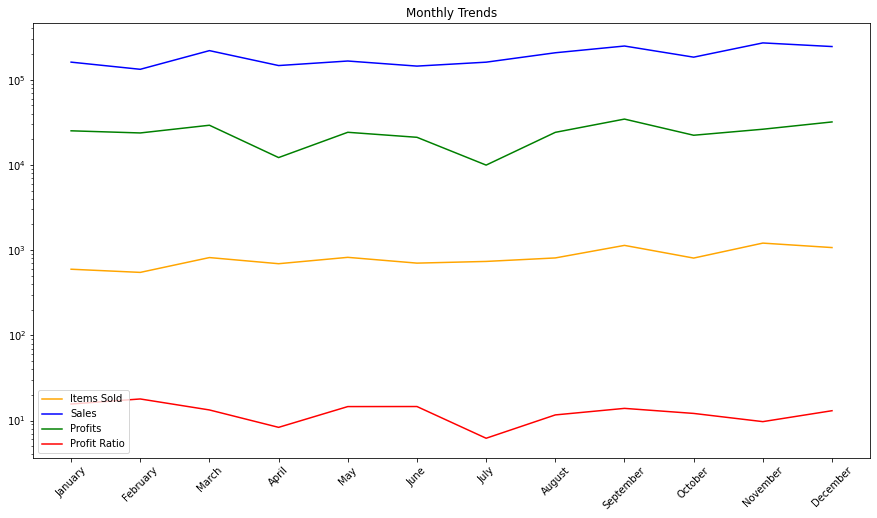

In [177]:
result['ProfitRatio'] = [float(x.replace('%', '')) for x in result['ProfitRatio']]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
labels = ['Items Sold', 'Sales', 'Profits', 'Profit Ratio']

fig, axes = plt.subplots(1, 1,figsize=(15, 8))

axes.plot(months, result['TotalSold'], color='orange', label=labels[0])
axes.plot(months, result['TotalSales'], color='blue', label=labels[1])
axes.plot(months, result['TotalProfit'], color='green', label=labels[2])
axes.plot(months, result['ProfitRatio'], color='red', label=labels[3])
axes.set_title('Monthly Trends')
axes.set_xticklabels(months, rotation=45)
axes.set_yscale('log')
axes.legend(labels, loc='lower left')


plt.show()

All Historical Sales - 4 Years of Super Store

In [174]:
query = '''
SELECT YEAR(OderDate) as 'Year'
       ,MONTH(OderDate) AS 'Month'
       ,COUNT(Sales)    AS TotalSold
       ,SUM(Sales)      AS TotalSales
       ,SUM(Profit)     AS TotalProfit
       , CONCAT(CAST(SUM(Profit)/SUM(Sales)*100 
              AS DECIMAL(10,2)), '%') as ProfitRatio
FROM Orders 
GROUP BY  YEAR(OderDate), MONTH(OderDate)
ORDER BY Year, Month;
'''
result = %sql $query
result = pd.DataFrame(result)
result

 * mssql+pyodbc://PLLUKOR1@local
Done.


,Year,Month,TotalSold,TotalSales,TotalProfit,ProfitRatio
0,2014,1,131,28953.71,4549.46,15.71%
1,2014,2,86,12743.12,2654.58,20.83%
2,2014,3,168,54801.96,92.68,0.17%
3,2014,4,119,24592.89,4556.02,18.53%
4,2014,5,148,29639.84,3912.23,13.20%
5,2014,6,136,29277.97,4497.87,15.36%
6,2014,7,156,35341.23,-1783.56,-5.05%
7,2014,8,146,35804.75,1476.70,4.12%
8,2014,9,238,66101.64,10228.44,15.47%
9,2014,10,144,34525.57,4062.90,11.77%


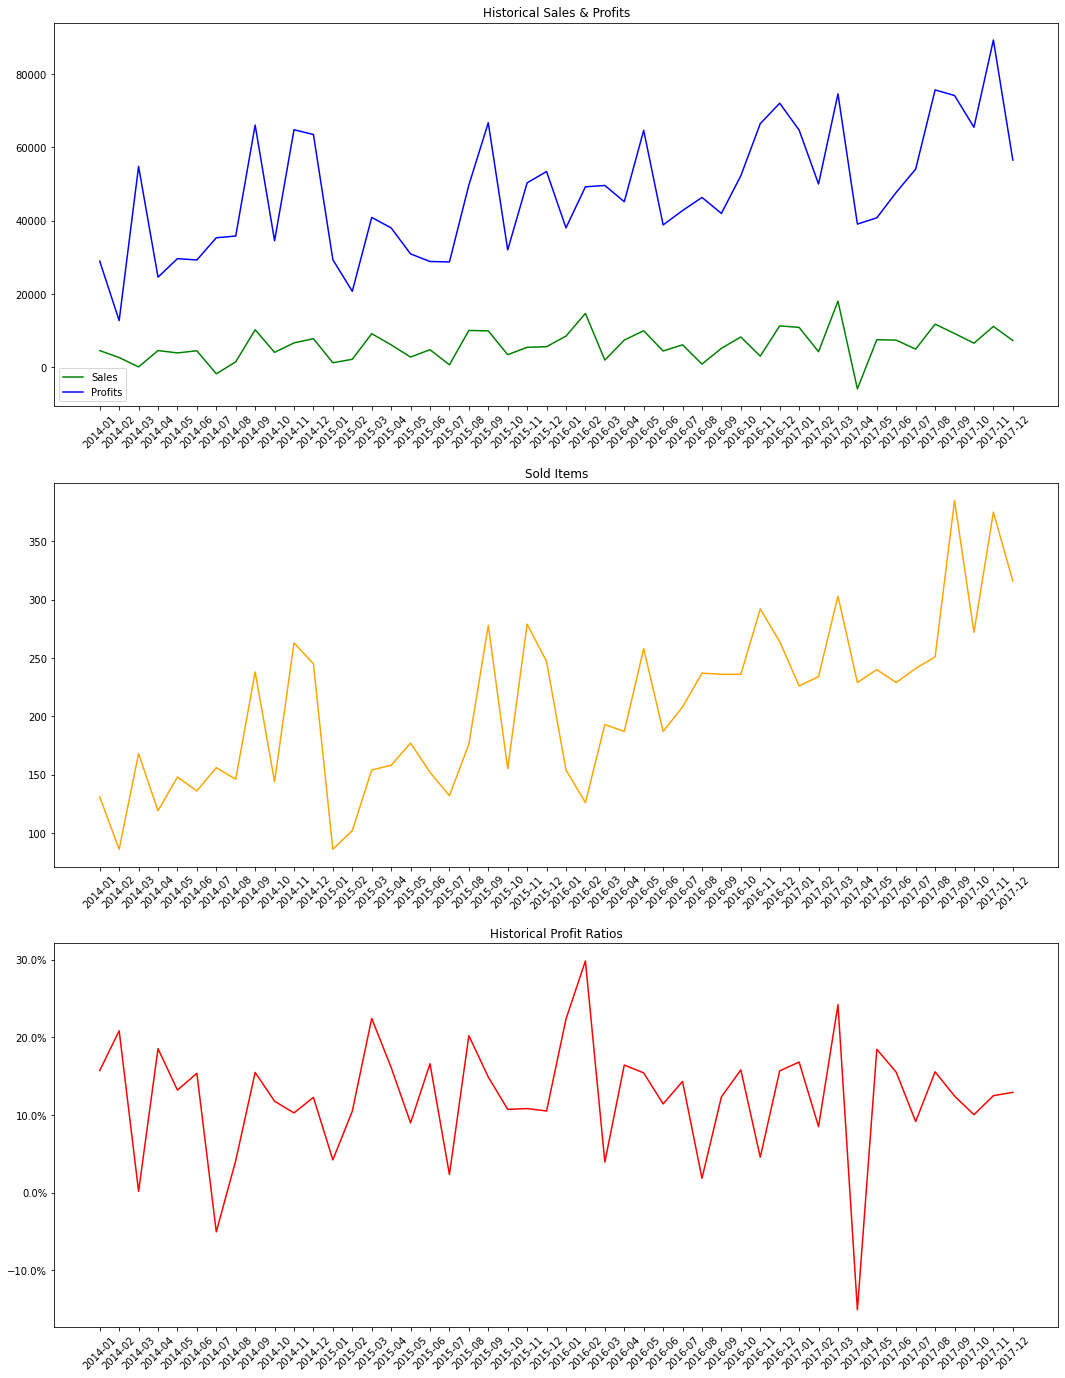

In [175]:
result['ProfitRatio'] = [float(x.replace('%', '')) for x in result['ProfitRatio']]
result['Month'] = ['0'+str(x) if len(str(x)) == 1 else str(x) for x in result['Month']]
result['Date'] = result['Year'].astype(str) + '-' + result['Month']

labels = ['Sales', 'Profits']

fig, axes = plt.subplots(3, 1,figsize=(18, 24))

axes[0].plot(result['Date'], result['TotalProfit'], color='green', label=labels[0])
axes[0].plot(result['Date'], result['TotalSales'], color='blue', label=labels[1])
axes[0].set_title('Historical Sales & Profits')
axes[0].set_xticklabels(result['Date'], rotation=45)
axes[0].legend(labels, loc='lower left')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%d$'))


axes[1].plot(result['Date'], result['TotalSold'], color='orange')
axes[1].set_title('Sold Items')
axes[1].set_xticklabels(result['Date'], rotation=45)


axes[2].plot(result['Date'], result['ProfitRatio'], color='red')
axes[2].set_title('Historical Profit Ratios')
axes[2].set_xticklabels(result['Date'], rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())

plt.show()


### Lesson learned